# Cancer Death Rates Based on Total Hospital Admissions & External Factors

- Amit Das (akdas)
- Pratap Gude (gvnsp)
- Eman Wong (emanwong)

Course: SI 618


In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from skimpy import clean_columns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir("C:/Users/gvnsp/SI618/618-main")

In [5]:
os.listdir('data')

['air_pollution_emissions.csv',
 'alcohol_expenditure_usa_long_term.csv',
 'cancer_death_rates_in_the_US_over_the_long_term.csv',
 'sales-of-cigarettes-per-adult-per-day.csv',
 'total-hospital-admissions-in-the-united-states-1946-2019.xlsx',
 'WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx']

# Load Data

In [6]:
DATA_DIR = 'data'
def data_path(filename, data_dir = DATA_DIR):
    return f"{data_dir}/{filename}"
air_pollution_filename = "air_pollution_emissions.csv"
alcohol_expenditure_filename = "alcohol_expenditure_usa_long_term.csv"
cancer_death_filename = "cancer_death_rates_in_the_US_over_the_long_term.csv"
hospital_admissions_filename = "total-hospital-admissions-in-the-united-states-1946-2019.xlsx"
demographic_indicators_filename = "WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx"
cigarette_sales_filename = "sales-of-cigarettes-per-adult-per-day.csv"

### Hospital Admissions

In [7]:
# read data
hospital_admissions = pd.read_excel(data_path(hospital_admissions_filename), 
                                    sheet_name = 1)
# remove junk columns & rows
hospital_admissions = hospital_admissions.drop(columns=['Unnamed: 0'])
hospital_admissions = hospital_admissions.iloc[4:,:]
# rename columns
hospital_admissions.rename(columns={'Unnamed: 1':'year', 
                                    'Unnamed: 2':'num_admissions_1000s'}, 
                                    inplace=True)
# fix type
hospital_admissions['year'] = pd.to_numeric(hospital_admissions['year'])
# set dates
hospital_admissions = hospital_admissions.loc[(hospital_admissions['year'] >= 1950) 
                                              & (hospital_admissions['year'] <= 2011)]
hospital_admissions.set_index('year', inplace=True)

In [8]:
hospital_admissions.head(10)

,num_admissions_1000s
year,
1950,18483.0
1955,21073.0
1960,25027.0
1965,28812.0
1970,31759.0
1971,32664.0
1972,33265.0
1973,34352.0
1974,35506.0


<AxesSubplot: xlabel='year'>

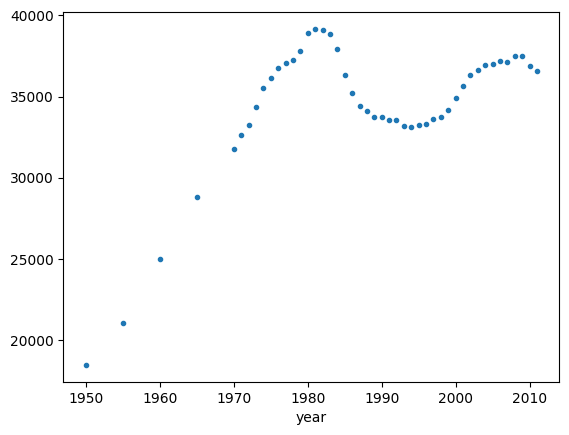

In [9]:
hospital_admissions['num_admissions_1000s'].plot(style='.')

### Demographic Indicators

In [10]:
# read data
demographic_indicators = pd.read_excel(data_path(demographic_indicators_filename), sheet_name=0)
# remove junk rows and set header
demographic_indicators_header = demographic_indicators.iloc[15,:]
demographic_indicators = demographic_indicators.iloc[16:,:]
demographic_indicators.columns = demographic_indicators_header
# select USA data
demographic_indicators = demographic_indicators.loc[demographic_indicators['Region, subregion, country or area *'] == 'United States of America']
# rename columns
demographic_indicators.rename(
    columns={'Year': 'year',
             'Total Population, as of 1 July (thousands)': 'total_population',
             'Male Population, as of 1 July (thousands)': 'male_population',
             'Female Population, as of 1 July (thousands)': 'female_population'},
    inplace=True)
# select relevant columns
demographic_cols = ['year', 'total_population', 'male_population', 'female_population']
demographic_indicators = demographic_indicators[demographic_cols]
# set dates and index
demographic_indicators = demographic_indicators.loc[(demographic_indicators['year'] >= 1950) & (demographic_indicators['year'] <= 2011)]
demographic_indicators.columns.name = None
demographic_indicators.set_index('year', inplace=True)
demographic_indicators

,total_population,male_population,female_population
year,,,
1950,148281.55,73516.095,74765.455
1951,150598.453,74784.499,75813.955
1952,152941.727,76079.283,76862.444
1953,155451.199,77221.443,78229.756
1954,158205.873,78577.893,79627.98
...,...,...,...
2007,302743.399,149147.06,153596.338
2008,305694.91,150592.791,155102.12
2009,308512.035,151968.684,156543.351


### Cancer Death Rates (per 100,000)

In [11]:
# read data
cancer_death = pd.read_csv(data_path(cancer_death_filename))
# set dates
cancer_death = cancer_death.loc[(cancer_death['Year'] >= 1950) & (cancer_death['Year'] <= 2011)]
# basic cleaning
cancer_death = clean_columns(cancer_death)
cancer_death.drop('entity', axis=1, inplace=True)
cancer_death.set_index('year', inplace=True)
cancer_death.head()

16 column names have been cleaned

,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,prostate_male,leukemia_male,stomach_female,colon_and_rectum_female,pancreas_female,lung_and_bronchus_female,breast_female,uterus_female,liver_female
year,,,,,,,,,,,,,,
1950,31.1,33.1,8.6,9.9,24.3,28.9,8.2,17.6,32.3,6.8,5.8,31.9,26.2,9.8
1951,29.7,32.3,8.3,10.3,25.8,28.6,8.7,16.5,31.9,6.7,5.9,31.6,24.5,9.4
1952,28.7,32.8,8.1,10.4,28.0,29.7,8.8,16.1,31.5,7.1,6.1,31.6,23.8,9.5
1953,28.1,33.0,8.0,10.7,30.4,29.8,9.1,15.6,31.4,7.1,6.0,32.2,23.6,9.2
1954,27.3,32.6,7.7,11.2,31.7,30.5,9.4,14.8,31.2,7.3,6.0,31.8,22.5,8.7


### Alcohol Expenditure

In [12]:
alcohol_expenditure = pd.read_csv(data_path(alcohol_expenditure_filename))
# select dates

# clean names
alcohol_expenditure = clean_columns(alcohol_expenditure)

# rename and subset relevant cols
alcohol_expenditure.rename(
    columns={'total_at_home_usda_2018': 'alc_exp_at_home',
             'total_away_from_home': 'alc_exp_away_fr_home',
             'total_alcohol_expenditure_usda_2018': 'alc_exp_total'},
    inplace=True
)
relevant_alc_cols = [
    'year',
    'alc_exp_at_home',
    'alc_exp_away_fr_home',
    'alc_exp_total'
]
alcohol_expenditure = alcohol_expenditure[relevant_alc_cols]
# create lag features
lags = [10, 20, 30]
for col in relevant_alc_cols[1:]:
    for lag in lags:
        lag_col = f"{col}_lag{lag}"
        alcohol_expenditure[lag_col] = alcohol_expenditure[col].shift(lag)
# set index and subset years
alcohol_expenditure = alcohol_expenditure.loc[(alcohol_expenditure['year'] >= 1950) & (alcohol_expenditure['year'] <= 2011)]
alcohol_expenditure.set_index('year', inplace=True)

alcohol_expenditure

11 column names have been cleaned

,alc_exp_at_home,alc_exp_away_fr_home,alc_exp_total,alc_exp_at_home_lag10,alc_exp_at_home_lag20,alc_exp_at_home_lag30,alc_exp_away_fr_home_lag10,alc_exp_away_fr_home_lag20,alc_exp_away_fr_home_lag30,alc_exp_total_lag10,alc_exp_total_lag20,alc_exp_total_lag30
year,,,,,,,,,,,,
1950,3455000000,4413000000,7868000000,9.770000e+08,NaN,NaN,1.602000e+09,NaN,NaN,2.579000e+09,NaN,NaN
1951,3789000000,4765000000,8554000000,1.180000e+09,NaN,NaN,1.914000e+09,NaN,NaN,3.094000e+09,NaN,NaN
1952,3999000000,4899000000,8898000000,1.586000e+09,NaN,NaN,2.368000e+09,NaN,NaN,3.954000e+09,NaN,NaN
1953,4080000000,4960000000,9040000000,1.981000e+09,NaN,NaN,2.998000e+09,NaN,NaN,4.979000e+09,NaN,NaN
1954,4189000000,4946000000,9135000000,2.379000e+09,NaN,NaN,3.432000e+09,NaN,NaN,5.811000e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,69742656717,67992000000,137734656717,4.042086e+10,3.060304e+10,1.823500e+10,4.135400e+10,2.886700e+10,1.496000e+10,8.177486e+10,5.947004e+10,3.319500e+10
2008,79031284048,69884000000,148915284048,4.293135e+10,3.084603e+10,1.961200e+10,4.560300e+10,3.026700e+10,1.666800e+10,8.853435e+10,6.111303e+10,3.628000e+10
2009,78302523841,68655000000,146957523841,4.532177e+10,3.227780e+10,2.191100e+10,5.058000e+10,3.103900e+10,1.889300e+10,9.590177e+10,6.331680e+10,4.080400e+10


### Air Pollution

In [13]:
# read data
air_pollution = pd.read_csv(data_path(air_pollution_filename), low_memory=False)
# select USA data
air_pollution = air_pollution.loc[air_pollution['Entity'] == 'United States']
# fix column dtype
air_pollution['nh3_per_capita'] = pd.to_numeric(air_pollution['nh3_per_capita'])
# clean names and set index
air_pollution = clean_columns(air_pollution)
# subset cols
air_pol_rel_cols = [
    'year',
    'nox_per_capita', 
    'so_2_per_capita', 
    'co_per_capita', 
    'oc_per_capita',
    'nmvoc_per_capita', 
    'bc_per_capita', 
    'nh_3_per_capita'
]
air_pollution = air_pollution[air_pol_rel_cols]

# create lag features
lags = [10, 20, 30]
for col in air_pol_rel_cols[1:]:
    for lag in lags:
        lag_col = f"{col}_lag{lag}"
        air_pollution[lag_col] = air_pollution[col].shift(lag)

# subset dates and set index
air_pollution = air_pollution.loc[(air_pollution['year'] >= 1950) & (air_pollution['year'] <= 2011)]
air_pollution.set_index('year', inplace=True)

air_pollution.head()

6 column names have been cleaned

,nox_per_capita,so_2_per_capita,co_per_capita,oc_per_capita,nmvoc_per_capita,bc_per_capita,nh_3_per_capita,nox_per_capita_lag10,nox_per_capita_lag20,nox_per_capita_lag30,...,oc_per_capita_lag30,nmvoc_per_capita_lag10,nmvoc_per_capita_lag20,nmvoc_per_capita_lag30,bc_per_capita_lag10,bc_per_capita_lag20,bc_per_capita_lag30,nh_3_per_capita_lag10,nh_3_per_capita_lag20,nh_3_per_capita_lag30
year,,,,,,,,,,,,,,,,,,,,,
1950,87.872567,113.791573,660.499190,6.120093,106.463437,3.749932,9.289717,77.165886,65.272762,52.778905,...,13.059638,86.146689,74.035092,65.265225,3.753883,4.608253,6.885877,8.087318,8.094736,7.332490
1951,92.284438,117.679654,681.203964,5.698752,111.268008,3.501867,9.570112,80.869628,58.398253,48.989746,...,11.682725,88.638057,68.036087,62.298414,3.989941,3.881714,5.775849,8.207000,7.935655,7.300943
1952,92.125837,111.202933,680.903893,5.305718,112.090448,3.221975,9.744620,80.073479,52.121063,52.419322,...,11.397630,87.207958,62.230332,65.861795,4.189775,3.257480,5.688874,8.155423,7.742165,7.410596
1953,93.192457,111.909954,690.662295,4.836261,114.208577,2.935008,9.946302,83.634673,56.337560,63.763995,...,12.789408,90.970960,66.689566,76.922275,4.190680,3.378748,7.119476,8.255380,7.776478,7.669434
1954,90.616479,102.869296,674.088049,4.476236,112.303428,2.655331,10.007221,91.135738,57.583666,59.507127,...,11.811036,99.049593,67.118094,72.506306,4.360776,3.473152,6.357700,8.466189,7.721901,7.599375


### Cigarettes Sold Per Adult Per Day

In [14]:
# read data
cigarette_sales = pd.read_csv(data_path(cigarette_sales_filename))
# clean column names and subset data
cigarette_sales = clean_columns(cigarette_sales)
cigarette_sales = cigarette_sales.loc[cigarette_sales['code'] == 'USA']
cigarette_sales.drop(columns=['entity', 'code'], inplace=True)
cigarette_sales.columns = ['year', 'cigarettes_sold_per_adult']
# introduce time lag features
cigarette_sales['cigarettes_sold_per_adult_lag10'] = cigarette_sales['cigarettes_sold_per_adult'].shift(10)
cigarette_sales['cigarettes_sold_per_adult_lag20'] = cigarette_sales['cigarettes_sold_per_adult'].shift(20)
cigarette_sales['cigarettes_sold_per_adult_lag30'] = cigarette_sales['cigarettes_sold_per_adult'].shift(30)
# get relevant dates
cigarette_sales = cigarette_sales.loc[(cigarette_sales['year'] >= 1950) & (cigarette_sales['year'] <= 2011)]
cigarette_sales.set_index('year', inplace=True)

cigarette_sales.head()

4 column names have been cleaned

,cigarettes_sold_per_adult,cigarettes_sold_per_adult_lag10,cigarettes_sold_per_adult_lag20,cigarettes_sold_per_adult_lag30
year,,,,
1950,9.3,6.5,4.3,1.7
1951,9.8,6.8,4.3,1.9
1952,10.0,7.4,4.4,1.9
1953,9.7,7.8,4.8,2.3
1954,9.2,7.0,5.3,2.5


# Data Wrangling

#### Hospital admissions

Between 1950 and 1970, the data is recorded every 5 years. We will have to introduce the missing years into the data and fill in the missing values (using pandas' interpolation).

In [15]:
hospital_admissions = hospital_admissions.reindex(range(1950, 2012))
hospital_admissions.head(7)

,num_admissions_1000s
year,
1950,18483.0
1951,NaN
1952,NaN
1953,NaN
1954,NaN
1955,21073.0
1956,NaN


We try 3 methods of interpolation – linear, quadratic and cubic, and plot their values.

In [16]:
hospital_admissions['linear'] = hospital_admissions.interpolate(method='linear')['num_admissions_1000s']
hospital_admissions['quadratic'] = hospital_admissions.interpolate(method='quadratic')['num_admissions_1000s']
hospital_admissions['cubic'] = hospital_admissions.interpolate(method='cubic')['num_admissions_1000s']

Text(0.5, 1.0, 'Cubic Interpolation')

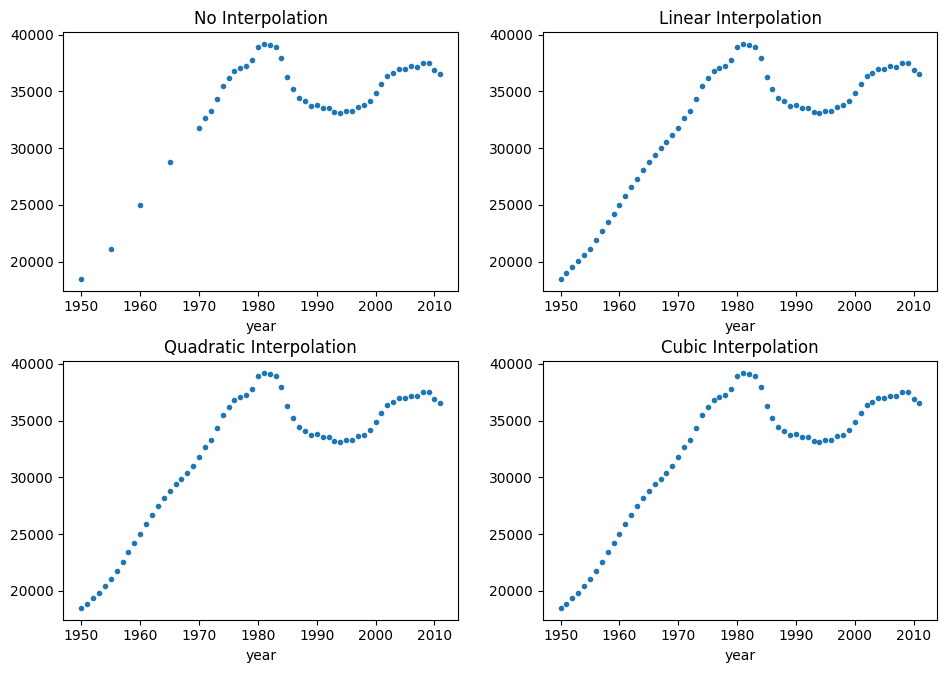

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10,7))
fig.tight_layout(pad=3.0)
hospital_admissions['num_admissions_1000s'].plot(style='.',ax=axes[0,0])
hospital_admissions['linear'].plot(style='.', ax=axes[0,1])
hospital_admissions['quadratic'].plot(style='.', ax=axes[1,0])
hospital_admissions['quadratic'].plot(style='.', ax=axes[1,1])
axes[0,0].set_title("No Interpolation")
axes[0,1].set_title("Linear Interpolation")
axes[1,0].set_title("Quadratic Interpolation")
axes[1,1].set_title("Cubic Interpolation")

We see that the quadratic interpolation appears to give more realistic looking values when simply comparin their plots. When using cubic interpolation, we see that there does not appear to be any significant difference compared to the quadratic interpolation, and thus we settle on the quadratic interpolation, so as to avoid potential overfitting with a higher order polynomial interoplation.

In [18]:
hospital_admissions.interpolate(method='quadratic', inplace=True)

We are interested in the admissions per capita, and as such, in our pre-processing step we will multiply the `num_admissions_1000s` column by $1000$ in order to achieve the approximate raw number of approximations, which we will later divide by the population.

In [19]:
hospital_admissions['num_admissions_total'] =  hospital_admissions['num_admissions_1000s'] * 1000
hospital_admissions.head()

,num_admissions_1000s,linear,quadratic,cubic,num_admissions_total
year,,,,,
1950,18483.000000,18483.0,18483.000000,18483.000000,1.848300e+07
1951,18874.298477,19001.0,18874.298477,18833.634720,1.887430e+07
1952,19328.947715,19519.0,19328.947715,19277.659627,1.932895e+07
1953,19846.947715,20037.0,19846.947715,19805.367173,1.984695e+07
1954,20428.298477,20555.0,20428.298477,20407.049813,2.042830e+07


#### Joining and Further Processing

In [20]:
merged_df = hospital_admissions.copy()
dfs_to_merge = [
    demographic_indicators,
    cancer_death,
    alcohol_expenditure,
    air_pollution,
    cigarette_sales
]

In [21]:
for df in dfs_to_merge:
    merged_df = merged_df.merge(
        df, 
        how='left',
        left_index=True,
        right_index=True,
        suffixes=(None, None)
    )
merged_df.head()

,num_admissions_1000s,linear,quadratic,cubic,num_admissions_total,total_population,male_population,female_population,stomach_male,colon_and_rectum_male,...,bc_per_capita_lag10,bc_per_capita_lag20,bc_per_capita_lag30,nh_3_per_capita_lag10,nh_3_per_capita_lag20,nh_3_per_capita_lag30,cigarettes_sold_per_adult,cigarettes_sold_per_adult_lag10,cigarettes_sold_per_adult_lag20,cigarettes_sold_per_adult_lag30
year,,,,,,,,,,,,,,,,,,,,,
1950,18483.000000,18483.0,18483.000000,18483.000000,1.848300e+07,148281.55,73516.095,74765.455,31.1,33.1,...,3.753883,4.608253,6.885877,8.087318,8.094736,7.332490,9.3,6.5,4.3,1.7
1951,18874.298477,19001.0,18874.298477,18833.634720,1.887430e+07,150598.453,74784.499,75813.955,29.7,32.3,...,3.989941,3.881714,5.775849,8.207000,7.935655,7.300943,9.8,6.8,4.3,1.9
1952,19328.947715,19519.0,19328.947715,19277.659627,1.932895e+07,152941.727,76079.283,76862.444,28.7,32.8,...,4.189775,3.257480,5.688874,8.155423,7.742165,7.410596,10.0,7.4,4.4,1.9
1953,19846.947715,20037.0,19846.947715,19805.367173,1.984695e+07,155451.199,77221.443,78229.756,28.1,33.0,...,4.190680,3.378748,7.119476,8.255380,7.776478,7.669434,9.7,7.8,4.8,2.3
1954,20428.298477,20555.0,20428.298477,20407.049813,2.042830e+07,158205.873,78577.893,79627.98,27.3,32.6,...,4.360776,3.473152,6.357700,8.466189,7.721901,7.599375,9.2,7.0,5.3,2.5


In [22]:
merged_df.columns

Index(['num_admissions_1000s', 'linear', 'quadratic', 'cubic',
       'num_admissions_total', 'total_population', 'male_population',
       'female_population', 'stomach_male', 'colon_and_rectum_male',
       'liver_male', 'pancreas_male', 'lung_and_bronchus_male',
       'prostate_male', 'leukemia_male', 'stomach_female',
       'colon_and_rectum_female', 'pancreas_female',
       'lung_and_bronchus_female', 'breast_female', 'uterus_female',
       'liver_female', 'alc_exp_at_home', 'alc_exp_away_fr_home',
       'alc_exp_total', 'alc_exp_at_home_lag10', 'alc_exp_at_home_lag20',
       'alc_exp_at_home_lag30', 'alc_exp_away_fr_home_lag10',
       'alc_exp_away_fr_home_lag20', 'alc_exp_away_fr_home_lag30',
       'alc_exp_total_lag10', 'alc_exp_total_lag20', 'alc_exp_total_lag30',
       'nox_per_capita', 'so_2_per_capita', 'co_per_capita', 'oc_per_capita',
       'nmvoc_per_capita', 'bc_per_capita', 'nh_3_per_capita',
       'nox_per_capita_lag10', 'nox_per_capita_lag20', 'nox_per_cap

In [23]:
df = merged_df.copy()

We have all the data joined and will perform the following processing:
1. Get the hospital admissions per capita
2. Get the complete death rate for each cancer type (remove separation by gender)
3. Get the complete death rate from all types of cancer
4. Get the alcohol expenditure values per capita

In [24]:
# get hospital admissions per capita
df['admissions_per_capita'] = df['num_admissions_total'] / df['total_population']

In [25]:
def cancer_deaths_helper(df, cancer_type):
    n_indiv = 100_000
    male_col = f"{cancer_type}_male"
    female_col = f"{cancer_type}_female"
    try:
        male_deaths = (df[male_col] / n_indiv) * df['male_population']
    except Exception as e:
        male_deaths = 0
    try:
        female_deaths = (df[female_col] / n_indiv) * df['female_population']
    except Exception as e:
        female_deaths = 0
    deaths = male_deaths + female_deaths
    total_rate = deaths / df['total_population']
    return total_rate

In [26]:
# get death rate per cancer type
cancer_types = ['stomach', 'colon_and_rectum', 'liver', 'pancreas', 
                'lung_and_bronchus','prostate', 'leukemia', 'breast', 'uterus']

for cancer_type in cancer_types:
    df[cancer_type] = cancer_deaths_helper(df, cancer_type)


In [27]:
# get cancer death rates total
df['all_cancer'] = 0
for cancer_type in cancer_types:
    df['all_cancer'] += df[cancer_type]

In [28]:
# get alcohol expenditure per capita
alc_cols = [
    'alc_exp_at_home', 'alc_exp_away_fr_home',
    'alc_exp_total', 'alc_exp_at_home_lag10', 'alc_exp_at_home_lag20',
    'alc_exp_at_home_lag30', 'alc_exp_away_fr_home_lag10',
    'alc_exp_away_fr_home_lag20', 'alc_exp_away_fr_home_lag30',
    'alc_exp_total_lag10', 'alc_exp_total_lag20', 'alc_exp_total_lag30',
]
for col in alc_cols:
    colname = f"{col}_pc"
    df[colname] = df[col] / df['total_population']


In [29]:
columns_of_interest = [
    'stomach_male', 'colon_and_rectum_male', 'liver_male', 
    'pancreas_male', 'lung_and_bronchus_male', 'prostate_male', 
    'leukemia_male', 'stomach_female', 'colon_and_rectum_female',
    'pancreas_female', 'lung_and_bronchus_female', 'breast_female', 
    'uterus_female', 'liver_female', 'nox_per_capita', 'so_2_per_capita', 
    'co_per_capita', 'oc_per_capita','nmvoc_per_capita', 'bc_per_capita', 
    'nh_3_per_capita','nox_per_capita_lag10', 'nox_per_capita_lag20', 
    'nox_per_capita_lag30','so_2_per_capita_lag10', 'so_2_per_capita_lag20',
    'so_2_per_capita_lag30', 'co_per_capita_lag10', 'co_per_capita_lag20',
    'co_per_capita_lag30', 'oc_per_capita_lag10', 'oc_per_capita_lag20',
    'oc_per_capita_lag30', 'nmvoc_per_capita_lag10','nmvoc_per_capita_lag20', 
    'nmvoc_per_capita_lag30','bc_per_capita_lag10', 'bc_per_capita_lag20', 
    'bc_per_capita_lag30', 'nh_3_per_capita_lag10', 'nh_3_per_capita_lag20',
    'nh_3_per_capita_lag30', 'cigarettes_sold_per_adult',
    'cigarettes_sold_per_adult_lag10', 'cigarettes_sold_per_adult_lag20',
    'cigarettes_sold_per_adult_lag30', 'admissions_per_capita', 'stomach',
    'colon_and_rectum', 'liver', 'pancreas', 'lung_and_bronchus','prostate', 
    'leukemia', 'breast', 'uterus', 'all_cancer','alc_exp_at_home_pc', 
    'alc_exp_away_fr_home_pc', 'alc_exp_total_pc',
    'alc_exp_at_home_lag10_pc', 'alc_exp_at_home_lag20_pc',
    'alc_exp_at_home_lag30_pc', 'alc_exp_away_fr_home_lag10_pc',
    'alc_exp_away_fr_home_lag20_pc', 'alc_exp_away_fr_home_lag30_pc',
    'alc_exp_total_lag10_pc', 'alc_exp_total_lag20_pc',
    'alc_exp_total_lag30_pc'
]
df_clean = df[columns_of_interest]

In [30]:
df_clean.head()

,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,prostate_male,leukemia_male,stomach_female,colon_and_rectum_female,pancreas_female,...,alc_exp_total_pc,alc_exp_at_home_lag10_pc,alc_exp_at_home_lag20_pc,alc_exp_at_home_lag30_pc,alc_exp_away_fr_home_lag10_pc,alc_exp_away_fr_home_lag20_pc,alc_exp_away_fr_home_lag30_pc,alc_exp_total_lag10_pc,alc_exp_total_lag20_pc,alc_exp_total_lag30_pc
year,,,,,,,,,,,,,,,,,,,,,
1950,31.1,33.1,8.6,9.9,24.3,28.9,8.2,17.6,32.3,6.8,...,53061.220361,6588.817017,NaN,NaN,10803.771609,NaN,NaN,17392.588626,NaN,NaN
1951,29.7,32.3,8.3,10.3,25.8,28.6,8.7,16.5,31.9,6.7,...,56800.052256,7835.405852,NaN,NaN,12709.2939,NaN,NaN,20544.699752,NaN,NaN
1952,28.7,32.8,8.1,10.4,28.0,29.7,8.8,16.1,31.5,7.1,...,58179.021347,10369.962672,NaN,NaN,15483.02119,NaN,NaN,25852.983862,NaN,NaN
1953,28.1,33.0,8.0,10.7,30.4,29.8,9.1,15.6,31.4,7.1,...,58153.298644,12743.549183,NaN,NaN,19285.79528,NaN,NaN,32029.344463,NaN,NaN
1954,27.3,32.6,7.7,11.2,31.7,30.5,9.4,14.8,31.2,7.3,...,57741.219253,15037.368429,NaN,NaN,21693.252816,NaN,NaN,36730.621246,NaN,NaN


In [31]:
df_clean = df_clean.astype(np.float64)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 1950 to 2011
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stomach_male                     62 non-null     float64
 1   colon_and_rectum_male            62 non-null     float64
 2   liver_male                       62 non-null     float64
 3   pancreas_male                    62 non-null     float64
 4   lung_and_bronchus_male           62 non-null     float64
 5   prostate_male                    62 non-null     float64
 6   leukemia_male                    62 non-null     float64
 7   stomach_female                   62 non-null     float64
 8   colon_and_rectum_female          62 non-null     float64
 9   pancreas_female                  62 non-null     float64
 10  lung_and_bronchus_female         62 non-null     float64
 11  breast_female                    62 non-null     float64
 12  uterus_female      

# EDA

In [32]:
def multiplePlots(series):

    fig, axs = plt.subplots(2, 2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

    # Histogram
    sns.histplot(series, ax=axs[0, 0])

    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(x=current, y=lag, fit_reg=False, ax=axs[0, 1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")

    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(x=xr, y=qntls, ax=axs[1, 0])

    # Run sequence
    ax = sns.regplot(x=np.arange(len(series)), y=series, ax=axs[1, 1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

### Gender Cancer Death Data

In [33]:
col_list_male= ['stomach_male', 'colon_and_rectum_male', 'liver_male',
                'pancreas_male','lung_and_bronchus_male', 'prostate_male', 
                'leukemia_male']

df_clean['Male_Cancer_Sum'] = df_clean[col_list_male].sum(axis=1)

col_list_female = ['stomach_female', 'colon_and_rectum_female', 
                'pancreas_female','lung_and_bronchus_female', 'breast_female',
                'uterus_female','liver_female']

df_clean['Female_Cancer_sum'] = df_clean[col_list_female].sum(axis=1)

<AxesSubplot: >

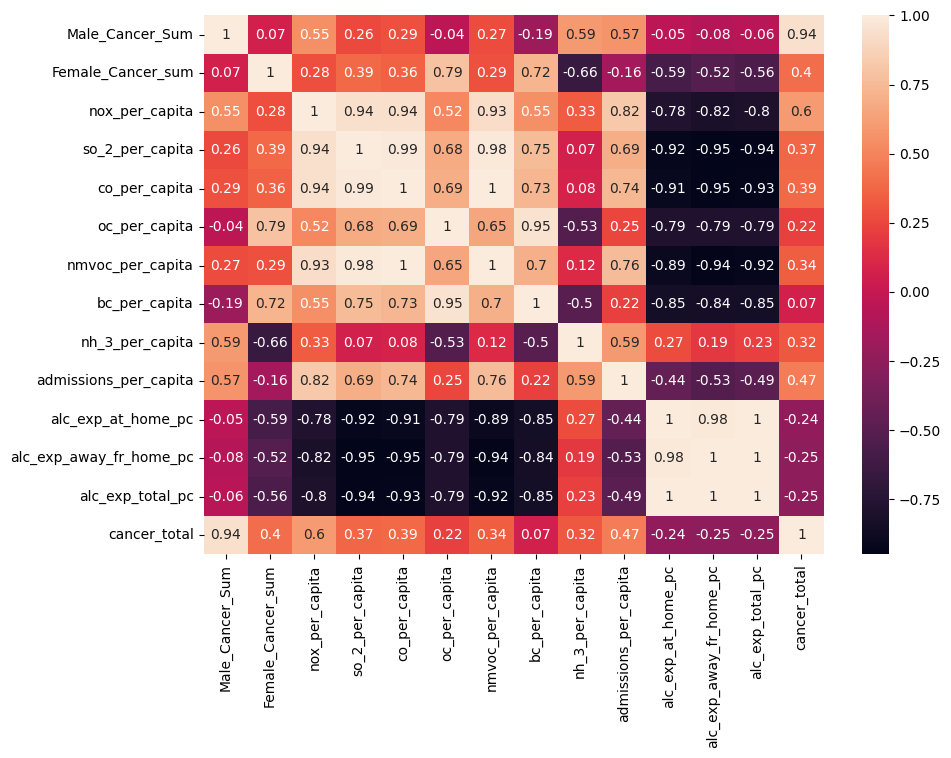

In [34]:
col_list = ['Male_Cancer_Sum','Female_Cancer_sum','nox_per_capita', 
    'so_2_per_capita', 'co_per_capita','oc_per_capita', 'nmvoc_per_capita', 
    'bc_per_capita', 'nh_3_per_capita','admissions_per_capita', 
    'alc_exp_at_home_pc', 'alc_exp_away_fr_home_pc', 'alc_exp_total_pc']

df_clean4 = df_clean[col_list]

df_clean4['cancer_total'] =  df_clean4['Male_Cancer_Sum']+ df_clean4['Female_Cancer_sum']

fig, ax = plt.subplots(figsize=(10, 7))
matrix = df_clean4.corr().round(2)
sns.heatmap(matrix, annot=True, ax= ax)

<AxesSubplot: >

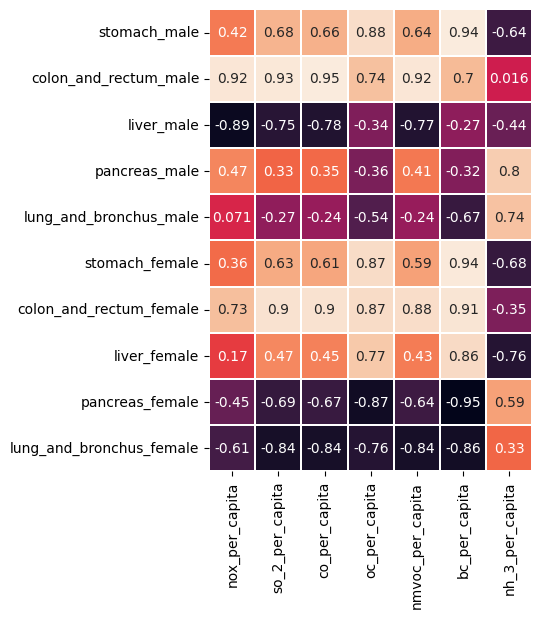

In [35]:
s23_cols = [
    'stomach_male', 'colon_and_rectum_male', 'liver_male', 'pancreas_male',
       'lung_and_bronchus_male','stomach_female', 'colon_and_rectum_female',
       'liver_female', 'pancreas_female','lung_and_bronchus_female', 
       'nox_per_capita', 'so_2_per_capita','co_per_capita','oc_per_capita', 
       'nmvoc_per_capita', 'bc_per_capita','nh_3_per_capita']

df_s23 = df_clean[s23_cols]

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_s23.corr(numeric_only=True).iloc[:10,10:], 
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

- The correlation coefficient between male cancer (0.59) and female cancer (-0.66) with NH3 per capita. In this instance, a moderately positive link between male cancer rates and NH3 emissions per capita is indicated by the positive correlation coefficient for male cancer and NH3 per capita of 0.59. This suggests that as NH3 emissions per person rise, male cancer rates tend to rise as well. It's crucial to remember that correlation does not imply causation and that other factors can be at play in the link that has been noticed. It's critical to undertake additional research and take other potential influences on cancer rates into account, such as age, genetics, lifestyle, and other environmental factor as correlation doesn't mean association.

- If the correlation between OC and BC emissions or concentrations with respect to per capita measurements is higher in females than in males, this indicates that there is a stronger association between OC and BC emissions or concentrations in females as compared to males. A larger correlation indicates that females, as opposed to males, are more frequently connected with changes in OC per capita and changes in BC per capita. There could be a number of explanations for this difference in correlation between males and females, including variations in exposure patterns, behaviors, or physiological traits between the sexes. The correlation between OC and BC emissions and their health effects may be altered by biological fluctuations, such as hormonal changes. To fully understand the underlying causes of the observed difference in correlation between males and females regarding OC and BC per capita, more research would be required. Given the limitations of correlation analysis and the need for further research to establish any causal connections or fully comprehend the patterns, it is crucial to take into account additional variables and factors that may be influencing the relationship and to interpret the results with caution.

### Total Cancer Death Data

In [36]:
df_clean1 = df_clean.copy()
total_cancer = df_clean1.drop(columns=['stomach_male', 'colon_and_rectum_male', 
       'liver_male', 'pancreas_male','lung_and_bronchus_male', 'prostate_male', 
       'leukemia_male','stomach_female', 'colon_and_rectum_female', 'pancreas_female',
       'lung_and_bronchus_female', 'breast_female', 'uterus_female',
       'liver_female', 'nox_per_capita', 'so_2_per_capita', 'co_per_capita',
       'oc_per_capita', 'nmvoc_per_capita', 'bc_per_capita', 'nh_3_per_capita',
       'admissions_per_capita', 'alc_exp_at_home_pc',
       'alc_exp_away_fr_home_pc', 'alc_exp_total_pc'])
total_cancer = total_cancer.astype(float)
total_cancer

,nox_per_capita_lag10,nox_per_capita_lag20,nox_per_capita_lag30,so_2_per_capita_lag10,so_2_per_capita_lag20,so_2_per_capita_lag30,co_per_capita_lag10,co_per_capita_lag20,co_per_capita_lag30,oc_per_capita_lag10,...,alc_exp_at_home_lag20_pc,alc_exp_at_home_lag30_pc,alc_exp_away_fr_home_lag10_pc,alc_exp_away_fr_home_lag20_pc,alc_exp_away_fr_home_lag30_pc,alc_exp_total_lag10_pc,alc_exp_total_lag20_pc,alc_exp_total_lag30_pc,Male_Cancer_Sum,Female_Cancer_sum
year,,,,,,,,,,,,,,,,,,,,,
1950,77.165886,65.272762,52.778905,126.443111,133.770913,161.859264,555.355003,518.505384,544.314433,6.910157,...,NaN,NaN,10803.771609,NaN,NaN,17392.588626,NaN,NaN,144.1,130.4
1951,80.869628,58.398253,48.989746,139.378212,108.476683,121.207044,578.335218,464.972381,492.838592,7.057684,...,NaN,NaN,12709.293900,NaN,NaN,20544.699752,NaN,NaN,143.7,126.5
1952,80.073479,52.121063,52.419322,149.228852,85.818958,120.872499,564.881733,416.597657,512.757563,7.209905,...,NaN,NaN,15483.021190,NaN,NaN,25852.983862,NaN,NaN,146.5,125.7
1953,83.634673,56.337560,63.763995,149.236359,92.750621,159.292990,583.537013,442.995531,612.196626,7.099553,...,NaN,NaN,19285.795280,NaN,NaN,32029.344463,NaN,NaN,149.1,125.1
1954,91.135738,57.583666,59.507127,152.626621,100.247313,140.165834,629.943928,446.603739,566.081986,7.152659,...,NaN,NaN,21693.252816,NaN,NaN,36730.621246,NaN,NaN,150.4,122.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,79.127806,94.774526,118.361325,62.687797,86.482324,122.550036,351.009084,576.669127,764.880580,1.851839,...,101085.753701,60232.527151,136597.528259,95351.377091,49414.785093,270112.783103,196437.130793,109647.312244,146.3,100.9
2008,76.891428,96.392603,117.136003,62.138851,87.535035,112.676813,339.715847,561.572230,769.183953,1.736686,...,100904.639227,64155.467947,149178.146277,99010.480744,54524.951037,289616.707239,199915.119970,118680.418984,143.2,99.3
2009,71.125871,94.530203,114.656943,56.455351,86.655613,110.686960,302.209741,532.244562,723.097590,1.755675,...,104624.119263,71021.540537,163948.223284,100608.716934,61239.102066,310852.591760,205232.836197,132260.642603,139.5,97.4


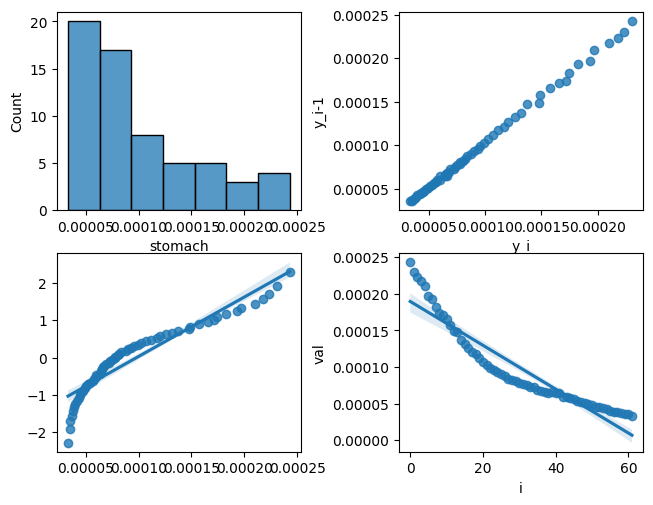

In [37]:
# total stomach cancer
multiplePlots(total_cancer['stomach'])

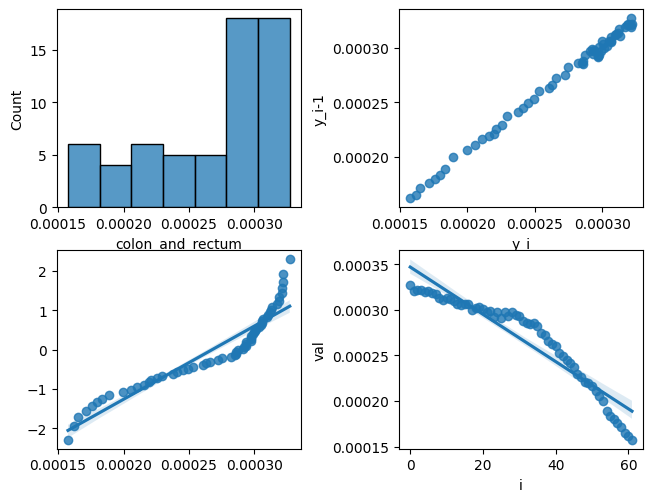

In [38]:
# total colon and rectum cancer
multiplePlots(total_cancer['colon_and_rectum'])

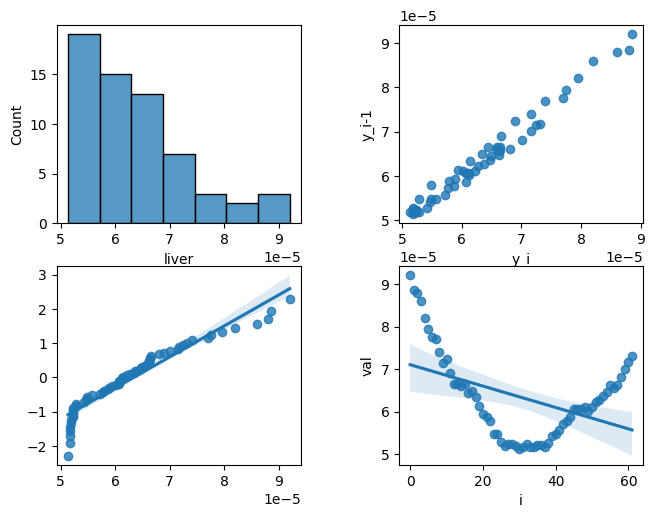

In [39]:
# total liver cancer
multiplePlots(total_cancer['liver'])

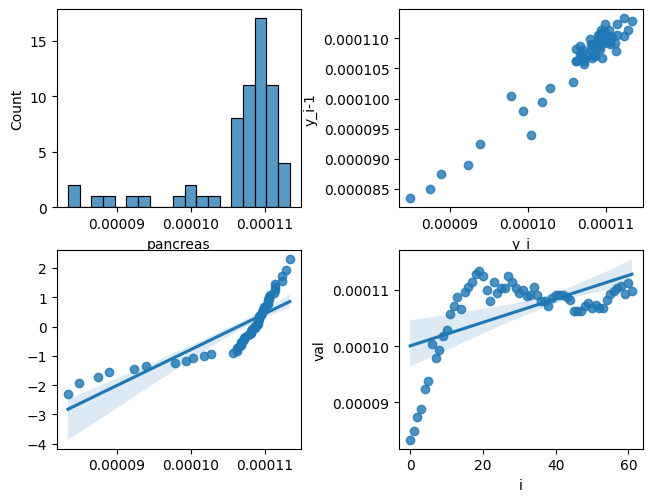

In [40]:
# total pancreas cancer
multiplePlots(total_cancer['pancreas'])

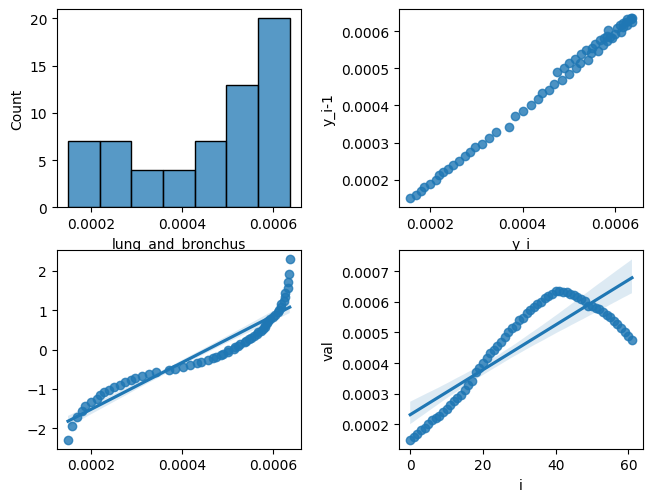

In [41]:
# total lung and bronchus cancer
multiplePlots(total_cancer['lung_and_bronchus'])

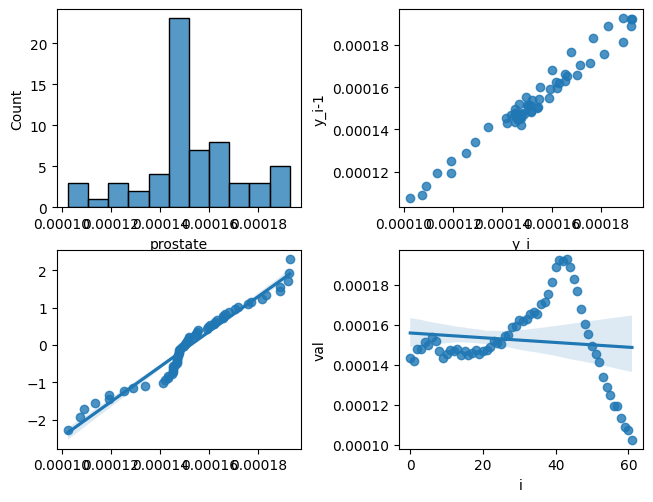

In [42]:
# total prostate cancer
multiplePlots(total_cancer['prostate'])

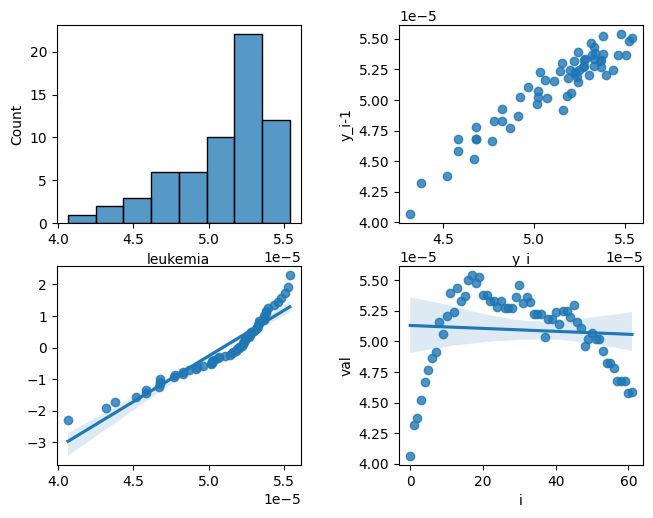

In [43]:
# total leukemia cancer
multiplePlots(total_cancer['leukemia'])

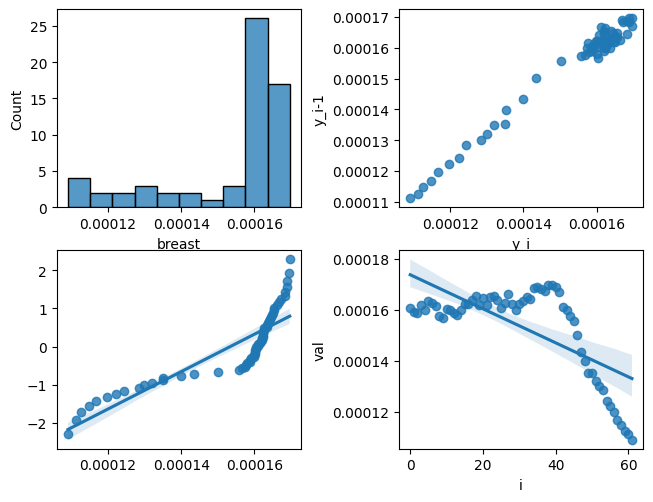

In [44]:
# total breast cancer
multiplePlots(total_cancer['breast'])

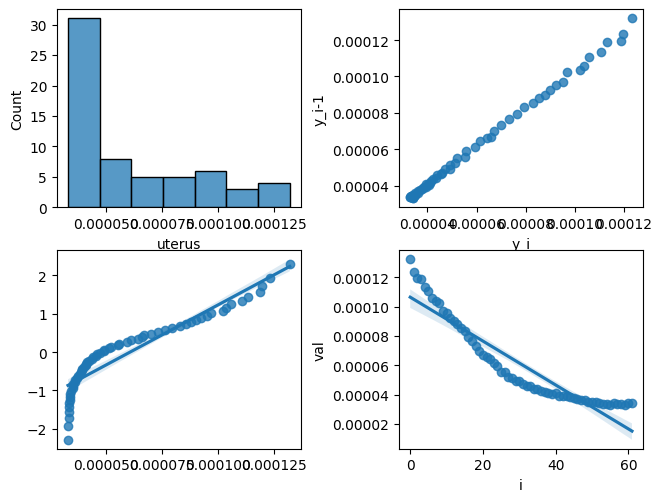

In [45]:
# total uterus cancer
multiplePlots(total_cancer['uterus'])

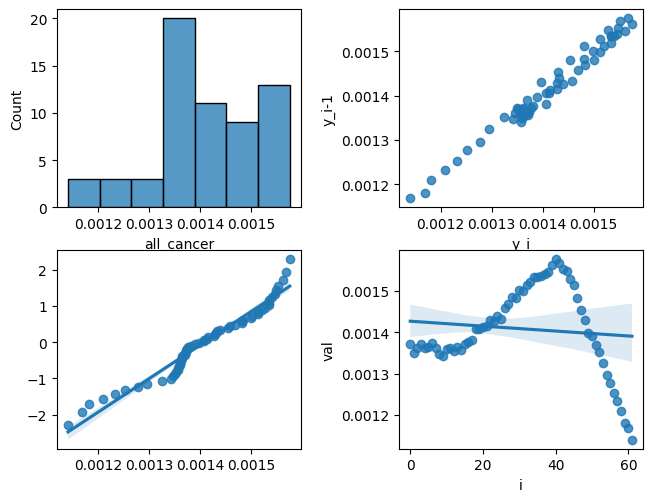

In [46]:
# total cancer
multiplePlots(total_cancer['all_cancer'])

<AxesSubplot: xlabel='year'>

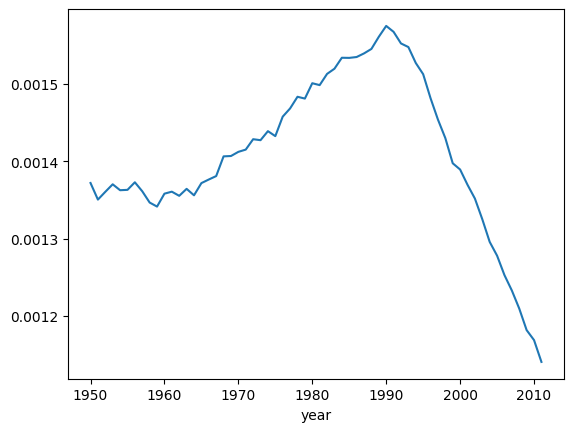

In [47]:
total_cancer['all_cancer'].plot()

<AxesSubplot: xlabel='year'>

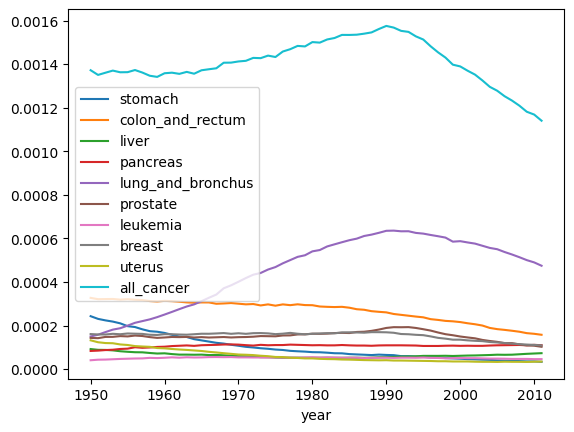

In [48]:
total_cancer.plot(y=['stomach', 'colon_and_rectum', 'liver', 'pancreas', 
                     'lung_and_bronchus', 'prostate', 'leukemia', 'breast', 
                     'uterus', 'all_cancer'])

In [49]:
df_clean.corr()

,stomach_male,colon_and_rectum_male,liver_male,pancreas_male,lung_and_bronchus_male,prostate_male,leukemia_male,stomach_female,colon_and_rectum_female,pancreas_female,...,alc_exp_at_home_lag20_pc,alc_exp_at_home_lag30_pc,alc_exp_away_fr_home_lag10_pc,alc_exp_away_fr_home_lag20_pc,alc_exp_away_fr_home_lag30_pc,alc_exp_total_lag10_pc,alc_exp_total_lag20_pc,alc_exp_total_lag30_pc,Male_Cancer_Sum,Female_Cancer_sum
stomach_male,1.000000,0.617239,-0.152724,-0.340628,-0.826766,-0.052305,-0.268410,0.996975,0.916017,-0.976867,...,-0.835004,-0.882843,-0.787108,-0.804661,-0.866189,-0.824246,-0.823877,-0.878480,-0.359954,0.697949
colon_and_rectum_male,0.617239,1.000000,-0.854703,0.238355,-0.099773,0.520731,0.466495,0.563502,0.869307,-0.610163,...,-0.959023,-0.958245,-0.949787,-0.970455,-0.907613,-0.919602,-0.967242,-0.939720,0.466729,0.530610
liver_male,-0.152724,-0.854703,1.000000,-0.575354,-0.359203,-0.613303,-0.777989,-0.085036,-0.525329,0.157909,...,0.835014,0.917861,0.710531,0.857570,0.859691,0.655866,0.847888,0.896020,-0.762293,-0.155849
pancreas_male,-0.340628,0.238355,-0.575354,1.000000,0.444605,0.055214,0.847717,-0.392766,-0.022109,0.350063,...,-0.497382,-0.673670,-0.151327,-0.420735,-0.627521,-0.138237,-0.464179,-0.656176,0.438776,-0.633411
lung_and_bronchus_male,-0.826766,-0.099773,-0.359203,0.444605,1.000000,0.535641,0.570381,-0.856160,-0.575939,0.802161,...,0.249875,-0.289729,0.366311,0.176257,-0.245670,0.444282,0.217264,-0.271950,0.818923,-0.374407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
alc_exp_total_lag10_pc,-0.824246,-0.919602,0.655866,-0.138237,0.444282,-0.189100,-0.247100,-0.785706,-0.976606,0.823812,...,0.969192,0.935949,0.994643,0.945508,0.894323,1.000000,0.961511,0.921170,-0.101405,-0.509318
alc_exp_total_lag20_pc,-0.823877,-0.967242,0.847888,-0.464179,0.217264,-0.451420,-0.695841,-0.780542,-0.965323,0.816935,...,0.997398,0.964223,0.972808,0.996182,0.914341,0.961511,1.000000,0.946034,-0.408103,-0.592319
alc_exp_total_lag30_pc,-0.878480,-0.939720,0.896020,-0.656176,-0.271950,-0.605893,-0.958194,-0.839970,-0.940985,0.822089,...,0.931058,0.997780,0.943855,0.955653,0.995841,0.921170,0.946034,1.000000,-0.731426,-0.567877
Male_Cancer_Sum,-0.359954,0.466729,-0.762293,0.438776,0.818923,0.854065,0.729119,-0.414238,-0.020440,0.352356,...,-0.370299,-0.747613,-0.193022,-0.451040,-0.704018,-0.101405,-0.408103,-0.731426,1.000000,0.072149


<AxesSubplot: >

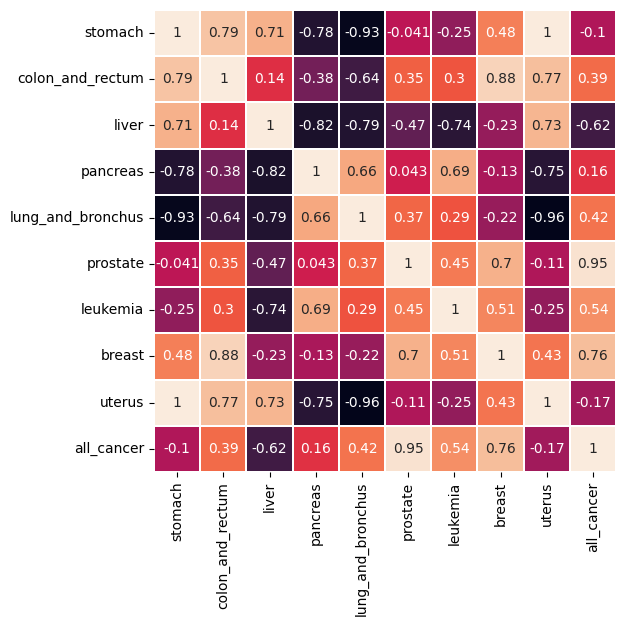

In [50]:
sa_cols = [
    'stomach', 'colon_and_rectum','liver', 'pancreas', 'lung_and_bronchus', 
    'prostate', 'leukemia', 'breast', 'uterus', 'all_cancer']
df_sa = total_cancer[sa_cols]

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_sa.corr(numeric_only=True), 
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

<AxesSubplot: xlabel='year'>

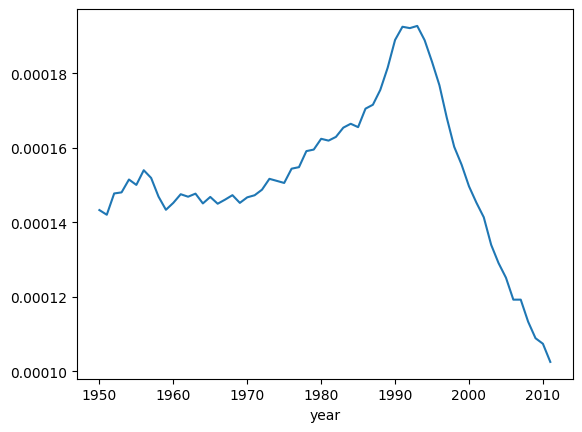

In [51]:
total_cancer['prostate'].plot()

<AxesSubplot: xlabel='year'>

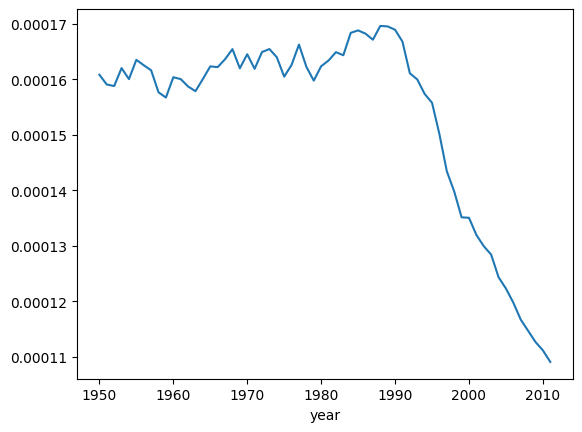

In [52]:
total_cancer['breast'].plot()

Most columns are not normally distributed and have either slight or heavy skews. For example, total stomach cancer has a right skew but total prostate cancer is heavily centered. However, the lag plot verifies that each column is consistent with time.

When plotting the yearly differences of the each cancer types, we can see that some cancers have spikes that are directly correlated to yearly data. Total cancer had a major spike between 1980 and 1990, and then linearly plummeted from 1990-2010. Total Lung cancer rates showed similar trends. While visualizing, we also verified that some cancers uterus, pancreas, liver, leukemia, etc. stayed constant throughout the years in the dataset. However, other cancers like colon and rectum, and stomach had drops compared to breast cancer that had a small increase between 1980-1990. Prostate cancer also had a small spike around 1990 and fell around 1995.

We wanted to test the correlation between different and total cancer to see if these trends line up with our findings. On the heatmap, we were surprised to see that breast and prostate cancer had higher correlations than lung and bronchus.

However, since lung and bronchus has a 0.42 correlation, we may infer that there is a small correlation to total cancer data. Prostate cancer having 0.95 correlation infers that there is a heavy correlation between the total and pancreatic cancer. Similar could be said about breast cancer with 0.76 correlation. Compared to lung cancer, prostate cancer has a similar graph to total cancer. Although lung cancer has a higher weight, but the graph moves a bit differently and we can see a slightly sharper drop on total cancer than lung cancer.

Another surprising thing we see is the '1' correlation between uterus and stomach cancer. Liver cancer had a decent correlation of 0.71 to stomach cancer while colon and rectum cancer had 0.79. The original line graph shows really similar slopes between uterus and stomach cancer.

Smaller findings are negative correlations in lung-uterus, lung-stomach, liver-pancreas, etc.

Since the weight of lung cancer is higher than others, its' contribution to total cancer is higher. The correlation is .42 (not low but not particularly high). However, when looking at the line plot, the other cancers have a very different distribution that affects the distribution of all cancer. This helps us understand why the correlations are different as compared to the weights of certain features.

In the multiple plots, we can see on the reg plots that both prostate and breast cancer have major drops that are harder to see on the complete line graph due to value size. We verified this through an individual line graph. Prostate cancer moves very similarly to total cancer.

## Further Analysis and Modelling

<AxesSubplot: >

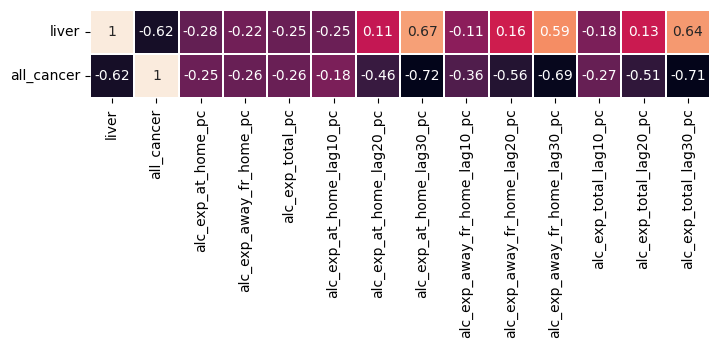

In [53]:
s1_cols = [
    'liver', 'all_cancer','alc_exp_at_home_pc', 'alc_exp_away_fr_home_pc', 
    'alc_exp_total_pc', 'alc_exp_at_home_lag10_pc', 'alc_exp_at_home_lag20_pc',
    'alc_exp_at_home_lag30_pc', 'alc_exp_away_fr_home_lag10_pc',
    'alc_exp_away_fr_home_lag20_pc', 'alc_exp_away_fr_home_lag30_pc',
    'alc_exp_total_lag10_pc', 'alc_exp_total_lag20_pc','alc_exp_total_lag30_pc']
df_s1 = df_clean[s1_cols]

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_s1.corr(numeric_only=True).iloc[:2,], 
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

<AxesSubplot: >

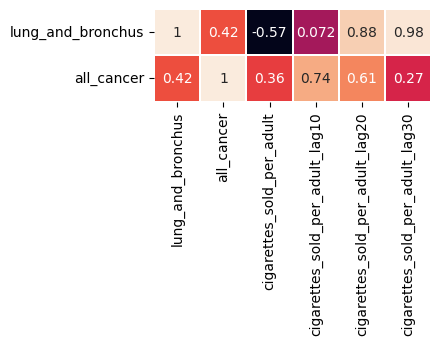

In [54]:
s1_cols = ['lung_and_bronchus', 'all_cancer', 'cigarettes_sold_per_adult', 
           'cigarettes_sold_per_adult_lag10', 'cigarettes_sold_per_adult_lag20', 
           'cigarettes_sold_per_adult_lag30']
df_s1 = df_clean[s1_cols]

fig, ax = plt.subplots(figsize=(5,1.2))
sns.heatmap(df_s1.corr(numeric_only=True).iloc[:2,], 
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

<AxesSubplot: >

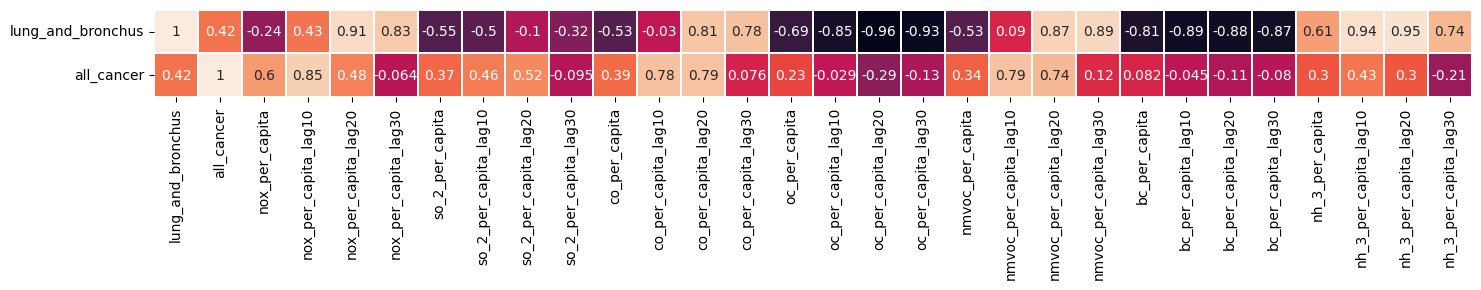

In [55]:
s2_cols = ['lung_and_bronchus', 'all_cancer', 
           'nox_per_capita', 'nox_per_capita_lag10', 'nox_per_capita_lag20', 
           'nox_per_capita_lag30','so_2_per_capita', 'so_2_per_capita_lag10', 
           'so_2_per_capita_lag20', 'so_2_per_capita_lag30',
           'co_per_capita', 'co_per_capita_lag10', 'co_per_capita_lag20', 
           'co_per_capita_lag30','oc_per_capita', 'oc_per_capita_lag10', 
           'oc_per_capita_lag20', 'oc_per_capita_lag30', 'nmvoc_per_capita', 
           'nmvoc_per_capita_lag10', 'nmvoc_per_capita_lag20',
           'nmvoc_per_capita_lag30','bc_per_capita', 'bc_per_capita_lag10', 
           'bc_per_capita_lag20', 'bc_per_capita_lag30',
           'nh_3_per_capita', 'nh_3_per_capita_lag10', 'nh_3_per_capita_lag20', 
           'nh_3_per_capita_lag30']
df_s2 = df_clean[s2_cols]
fig, ax = plt.subplots(figsize=(17,2))
sns.heatmap(df_s2.corr(numeric_only=True).iloc[:2,], 
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

In [56]:
lm_cols = [
    'all_cancer',
    'cigarettes_sold_per_adult', 'alc_exp_at_home_pc', 
    'alc_exp_away_fr_home_pc', 'alc_exp_total_pc',
    'alc_exp_at_home_lag10_pc', 'alc_exp_at_home_lag20_pc',
    'alc_exp_at_home_lag30_pc', 'alc_exp_away_fr_home_lag10_pc',
    'alc_exp_away_fr_home_lag20_pc', 'alc_exp_away_fr_home_lag30_pc',
    'alc_exp_total_lag10_pc', 'alc_exp_total_lag20_pc',
    'alc_exp_total_lag30_pc','cigarettes_sold_per_adult_lag10', 
    'cigarettes_sold_per_adult_lag20', 'cigarettes_sold_per_adult_lag30', 
    'nh_3_per_capita_lag30', 'nox_per_capita_lag10', 'nox_per_capita_lag20', 
    'nox_per_capita_lag30','so_2_per_capita_lag10', 'so_2_per_capita_lag20',
    'so_2_per_capita_lag30', 'co_per_capita_lag10', 'co_per_capita_lag20',
    'co_per_capita_lag30', 'oc_per_capita_lag10', 'oc_per_capita_lag20',
    'oc_per_capita_lag30', 'nmvoc_per_capita_lag10',
    'nmvoc_per_capita_lag20', 'nmvoc_per_capita_lag30',
    'bc_per_capita_lag10', 'bc_per_capita_lag20', 'bc_per_capita_lag30',
    'nh_3_per_capita_lag10', 'nh_3_per_capita_lag20', 'admissions_per_capita'
]
df_lm = df_clean[lm_cols]


<AxesSubplot: >

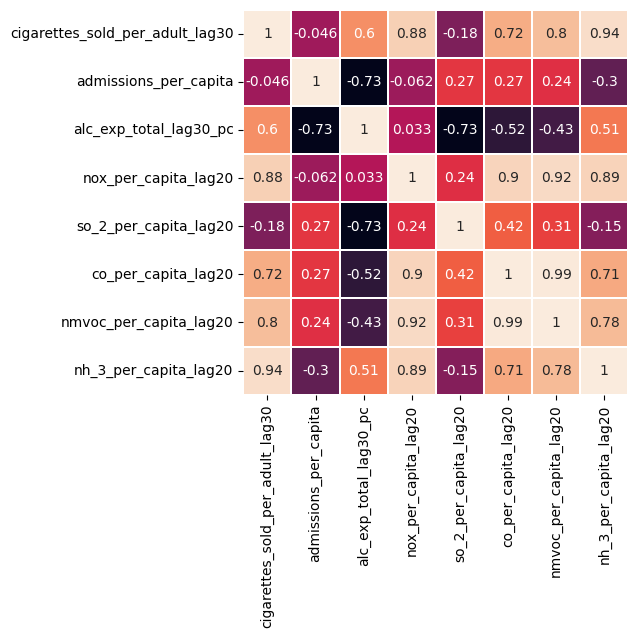

In [57]:
predictor_cols = [
    'cigarettes_sold_per_adult_lag30', 'admissions_per_capita',
    'alc_exp_total_lag30_pc', 'nox_per_capita_lag20', 
    'so_2_per_capita_lag20', 'co_per_capita_lag20',
    'nmvoc_per_capita_lag20', 'nh_3_per_capita_lag20'
]
df_a = df_lm[predictor_cols]

fig, ax = plt.subplots(figsize=(17,5))
sns.heatmap(df_a.corr(),
    cbar=False,
    xticklabels=True, 
    yticklabels=True, 
    linewidths=0.1, 
    annot=True, 
    annot_kws={"fontsize":10},
    ax=ax, 
    square=True)

In [58]:
model = ols(
    """
    all_cancer ~ cigarettes_sold_per_adult_lag30 + admissions_per_capita + 
        alc_exp_total_lag30_pc + so_2_per_capita_lag20
    """, 
    data=df_lm).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:             all_cancer   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     182.9
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           5.61e-26
Time:                        21:02:58   Log-Likelihood:                 428.81
No. Observations:                  47   AIC:                            -847.6
Df Residuals:                      42   BIC:                            -838.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 